In [17]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from models.model import EEGClassifier
from data_utils import Utils
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [3]:
channels = [["FC1", "FC2"],
            ["FC3", "FC4"],
            ["FC5", "FC6"],
            ["C5", "C6"],
            ["C3", "C4"],
            ["C1", "C2"],
            ["CP1", "CP2"],
            ["CP3", "CP4"],
            ["CP5", "CP6"]]

In [4]:
exclude =  [38, 88, 89, 92, 100, 104]
subjects = [n for n in np.arange(1,110) if n not in exclude]
source_path = 'data/'
x, y = Utils.load(channels, subjects, base_path=source_path)

In [5]:
y_one_hot  = Utils.to_one_hot(y, by_sub=False)
reshaped_x = x.reshape(x.shape[0], x.shape[1] * x.shape[2])

In [6]:
x_train_raw, x_valid_test_raw, y_train_raw, y_valid_test_raw = train_test_split(reshaped_x,
                                                                            y_one_hot,
                                                                            stratify=y_one_hot,
                                                                            test_size=0.20,
                                                                            random_state=42)

In [7]:
x_train_scaled_raw = minmax_scale(x_train_raw, axis=1)
x_test_valid_scaled_raw = minmax_scale(x_valid_test_raw, axis=1)

x_valid_raw, x_test_raw, y_valid, y_test = train_test_split(x_test_valid_scaled_raw,
                                                    y_valid_test_raw,
                                                    stratify=y_valid_test_raw,
                                                    test_size=0.50,
                                                    random_state=42)

x_valid = x_valid_raw.reshape(x_valid_raw.shape[0], int(x_valid_raw.shape[1]/2),2).astype(np.float64)
x_test = x_test_raw.reshape(x_test_raw.shape[0], int(x_test_raw.shape[1]/2),2).astype(np.float64)

In [8]:
print('classes count')
print ('before oversampling = {}'.format(y_train_raw.sum(axis=0)))

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
x_train_smote_raw, y_train = sm.fit_resample(x_train_scaled_raw, y_train_raw)
print('classes count')
print ('before oversampling = {}'.format(y_train_raw.sum(axis=0)))
print ('after oversampling = {}'.format(y_train.sum(axis=0)))

x_train = x_train_smote_raw.reshape(x_train_smote_raw.shape[0], int(x_train_smote_raw.shape[1]/2), 2).astype(np.float64)


classes count
before oversampling = [66744. 16553. 16826. 16610. 16546.]
classes count
before oversampling = [66744. 16553. 16826. 16610. 16546.]
after oversampling = [66744 66744 66744 66744 66744]


In [15]:
learning_rate = 1e-4
checkpoint_path = 'model_checkpoints/'
if not os.path.isdir(checkpoint_path):
    os.mkdir(checkpoint_path)
loss = tf.keras.losses.categorical_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model = EEGClassifier()
modelPath = os.path.join(checkpoint_path, 'bestModel.h5')

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])


In [18]:
checkpoint = ModelCheckpoint(
    modelPath,
    monitor='val_acc',
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    save_freq=1 
)

earlystopping = EarlyStopping(
    monitor='val_acc', 
    min_delta=0.001, 
    patience=4, 
    restore_best_weights=True, 
    verbose=0, 
)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
     factor=0.5, patience=4, 
     verbose=1, mode='auto', 
     min_lr=0.0000001
)
callbacksList = [checkpoint, earlystopping, reduce_lr, PlotLossesKeras()]

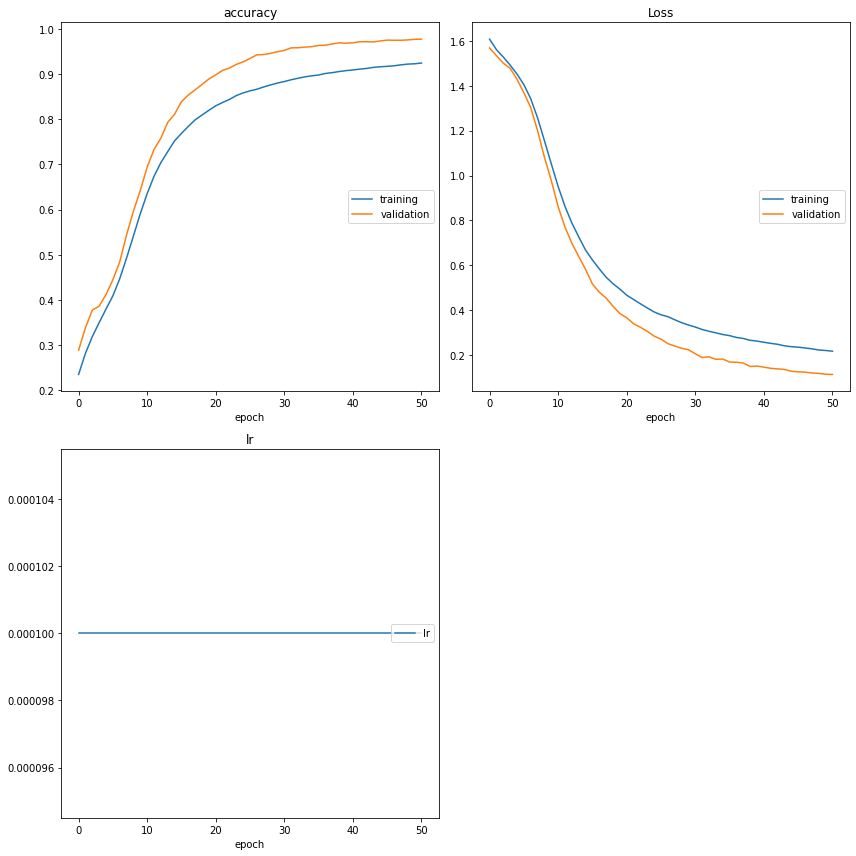

accuracy
	training         	 (min:    0.235, max:    0.924, cur:    0.924)
	validation       	 (min:    0.289, max:    0.977, cur:    0.977)
Loss
	training         	 (min:    0.218, max:    1.608, cur:    0.218)
	validation       	 (min:    0.114, max:    1.568, cur:    0.114)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
652/652 [==============================] - 18s 28ms/step - loss: 0.2176 - accuracy: 0.9243 - val_loss: 0.1139 - val_accuracy: 0.9771 - lr: 1.0000e-04
Epoch 52/100
355/652 [===============>..............] - ETA: 8s - loss: 0.2129 - accuracy: 0.9261

KeyboardInterrupt: 

In [19]:
import warnings 
warnings.filterwarnings('ignore')
import logging
tf.get_logger().setLevel(logging.ERROR)
hist = model.fit(x_train, y_train, epochs=100, batch_size=512,
                validation_data=(x_valid, y_valid), callbacks=callbacksList, verbose=1) 


In [21]:
save_path = os.path.join(checkpoint_path, 'bestModel')

model.save(save_path)


In [22]:

testLoss, testAcc = model.evaluate(x_test, y_test)
print('\nAccuracy:', testAcc)
print('\nLoss: ', testLoss)

from sklearn.metrics import classification_report, confusion_matrix
yPred = model.predict(x_test)

yTestClass = np.argmax(y_test, axis=1)
yPredClass = np.argmax(yPred,axis=1)

print('\n Classification report \n\n',
  classification_report(
      yTestClass,
      yPredClass,
       target_names=["B", "R", "RL", "L", "F"]
      )
  )

print('\n Confusion matrix \n\n',
  confusion_matrix(
      yTestClass,
      yPredClass,
      )
  )


521/521 [==============================] - 1s 2ms/step - loss: 0.1103 - accuracy: 0.9752

Accuracy: 0.9752100706100464

Loss:  0.11026991158723831
521/521 [==============================] - 1s 1ms/step

 Classification report 

               precision    recall  f1-score   support

           B       0.97      0.98      0.98      8343
           R       0.98      0.97      0.97      2069
          RL       0.98      0.96      0.97      2103
           L       0.98      0.96      0.97      2077
           F       0.98      0.96      0.97      2068

    accuracy                           0.98     16660
   macro avg       0.98      0.97      0.97     16660
weighted avg       0.98      0.98      0.98     16660


 Confusion matrix 

 [[8216   27   33   34   33]
 [  50 2006    8    1    4]
 [  64    6 2027    4    2]
 [  56    6    5 2004    6]
 [  61    4    5    4 1994]]
